# Implementation of the ER (Event Rejection) algorithm for four-jet signatures

In [26]:
from turtle import title
from h5py import File
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math

In [27]:
#Opening the HDF5 File
#input_file = "../user.maboelel.32438279._000005.output.h5"
input_file = "../forked_TDD/run/EBdata_Output_Dump/output.h5"
data = File(input_file, 'r')
print("List of available datasets: " + str(list(data.keys())))

List of available datasets: ['jets']


In [28]:
#Accessing the 'Jets' Dataset
jets = data['jets']
print("The attributes of each element of the dataset (jets): " + str(jets.dtype.fields.keys()))
print("The shape of the dataset is: " + str(jets.shape))

The attributes of each element of the dataset (jets): dict_keys(['pt', 'eta', 'fastDips_pb', 'fastDips_pc', 'fastDips_pu', 'fastGN120230327_pb', 'fastGN120230327_pc', 'fastGN120230327_pu', 'dipz20230223_z', 'dipz20230223_negLogSigma2', 'jetPtRank', 'mcEventWeight', 'eventNumber', 'averageInteractionsPerCrossing', 'actualInteractionsPerCrossing', 'nPrimaryVertices', 'primaryVertexBeamspotZ', 'primaryVertexDetectorZUncertainty'])
The shape of the dataset is: (22136,)


In [29]:
print("The number of jets in the sample is: " + str(len(jets)))
print("The number of jets in the sample with pT < 20 GeV is: " + str(len(jets[jets["pt"] < 20])))
print("The number of jets in the sample with eta > 2.5 GeV is: " + str(len(jets[jets["eta"] > 2.5])))

The number of jets in the sample is: 22136
The number of jets in the sample with pT < 20 GeV is: 0
The number of jets in the sample with eta > 2.5 GeV is: 0


In [30]:
#Getting the events in our sample
uniques = np.unique(jets["eventNumber"])
print("The number of events in our sample is: " + str(len(uniques)))
print("The events_ID array looks like: " + str(uniques))

The number of events in our sample is: 6253
The events_ID array looks like: [1117958940 1117959114 1117959199 ... 1144345763 1144346688 1144349488]


In [31]:
%%time
# Getting an array of the jet multiplicities in the sample
jet_multiplicities = []
for i in uniques:
    jet_multiplicities.append(len(jets[jets["eventNumber"] == i]))

CPU times: user 38.9 s, sys: 547 ms, total: 39.5 s
Wall time: 39.6 s


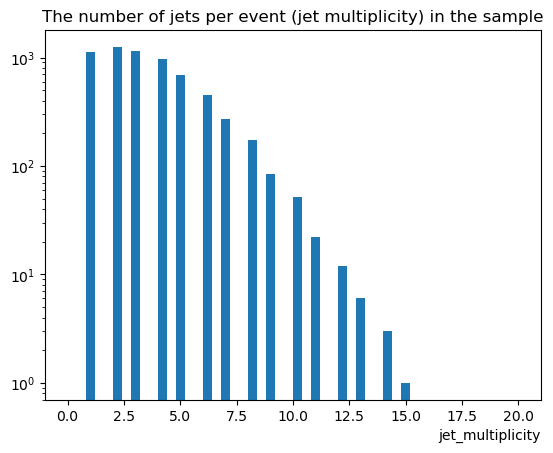

In [32]:
# Plotting the jet multiplicities in the sample
plt.hist(jet_multiplicities, bins = 50, range=(0,20))
plt.yscale('log')
plt.xlabel("jet_multiplicity", loc='right')
plt.title('The number of jets per event (jet multiplicity) in the sample')
plt.show()

In [33]:
%%time
# Getting an array of the leading jet pT's per event in the sample
leading_pT = []
for i in uniques:
    pTs = []
    event_jets = jets[jets["eventNumber"] == i]
    for jet in event_jets:
        pTs.append(jet["pt"])
    leading_pT.append(max(pTs))

CPU times: user 39.1 s, sys: 443 ms, total: 39.5 s
Wall time: 39.6 s


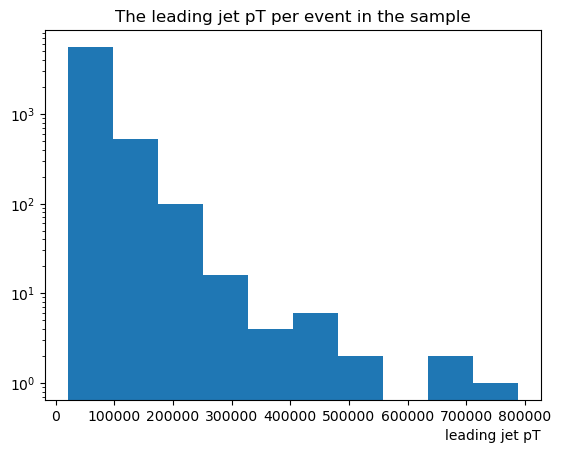

In [34]:
# Plotting the leading jet pT's per event in the sample
plt.hist(leading_pT, bins = 10)
plt.yscale('log')
plt.xlabel("leading jet pT", loc='right')
plt.title('The leading jet pT per event in the sample')
plt.show()

In [35]:
%%time
# Getting an array of the sub-leading jet pT's per event in the sample
subleading_pT = []
for i in uniques:
    pTs = []
    event_jets = jets[jets["eventNumber"] == i]
    for jet in event_jets:
        pTs.append(jet["pt"])
    if len(pTs) > 1: 
        subleading_pT.append(sorted(pTs)[-2])

CPU times: user 38.8 s, sys: 544 ms, total: 39.4 s
Wall time: 39.5 s


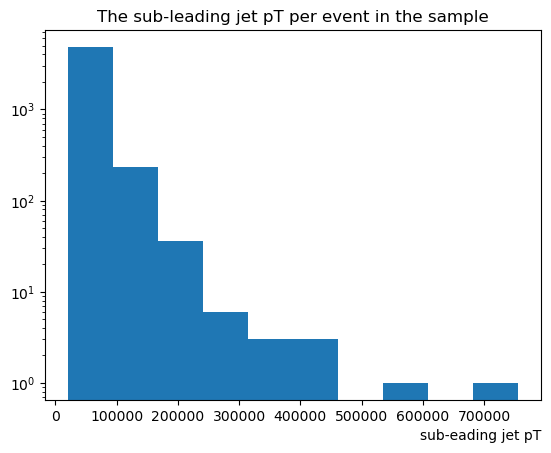

In [36]:
# Plotting the sub-leading jet pT's per event in the sample
plt.hist(subleading_pT, bins = 10)
plt.yscale('log')
plt.xlabel("sub-eading jet pT", loc='right')
plt.title('The sub-leading jet pT per event in the sample')
plt.show()

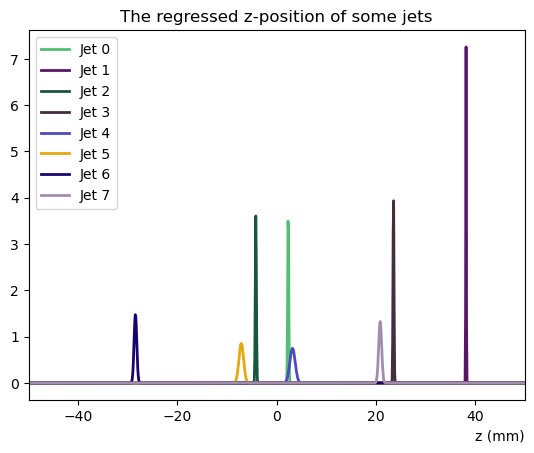

In [41]:
# Visualizing the jets in one event
event_id = uniques[3]
event_jets = jets[jets["eventNumber"] == event_id]
num_jets = len(event_jets)

import matplotlib.pyplot as plt
from scipy.stats import norm
import random
#Generating random colors for  the plot
color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
           for j in range(num_jets)]
ic = 0      #color counter
x = np.arange(-4*50, 4*50, 0.1)

for i in range(num_jets):
    #plt.plot(x, norm.pdf(x, event_jets[i]["dipz20230223_z"], np.exp(-0.5*event_jets[i]["dipz20230223_negLogSigma2"])), color=color[ic], linewidth=2, label='Jet '+str(ic))
    plt.plot(x, norm.pdf(x, event_jets[i]["dipz20230223_z"]*50, np.exp(-0.5*event_jets[i]["dipz20230223_negLogSigma2"])), color=color[ic], linewidth=2, label='Jet '+str(ic))
    ic = ic + 1    
plt.xlabel("z (mm)", loc='right')
plt.title('The regressed z-position of some jets')
plt.xlim([-1*50, 1*50])
plt.legend()
plt.show()
#plt.cla()

In [43]:
%%time

#Filtering the four-or-more jet events
fom_events = []
counter = 0

for id in uniques:
    if len(jets[jets["eventNumber"] == id]) >= 4:
        fom_events.append(id)
        counter +=1
    if counter == 10000:
        break

CPU times: user 38.9 s, sys: 443 ms, total: 39.3 s
Wall time: 39.4 s


In [44]:
%%time

import itertools as it

#list = jets[jets["eventNumber"] == fom_events[6]]

list = ['a', 'b', 'c', 'd', 'e']

combinations = []

for combination in it.combinations(list, 4):
    combinations.append(combination)
    
for comb in combinations:
    for jet in comb:
        print("hi")
        break
    break

print(combinations)

hi
[('a', 'b', 'c', 'd'), ('a', 'b', 'c', 'e'), ('a', 'b', 'd', 'e'), ('a', 'c', 'd', 'e'), ('b', 'c', 'd', 'e')]
CPU times: user 323 µs, sys: 6 µs, total: 329 µs
Wall time: 333 µs


In [51]:
# A function that takes in the event number and calculates the maximum over 4-jet combinations of log of the product of the 
# likelihood functions of all the jets in the event NUMERICALLY
import itertools as it

def get_max_log_likelihood_num(event_id):
    event_jets = jets[jets["eventNumber"] == event_id]
    #num_jets = len(event_jets)
    z = np.arange(-5*50, 5*50, 0.1)

    combinations = []
    mlpl_array = []

    for combination in it.combinations(event_jets, 4):
        combinations.append(combination)

    for comb in combinations:
        log_total_likelihood = -4 * np.log(np.sqrt(2*np.pi))
            
        for jet in comb:
            mu = jet["dipz20230223_z"] * 50
            sigma = np.exp(-0.5*jet["dipz20230223_negLogSigma2"]) *50
            #likelihood = (2*np.pi)**(-1/2) * (sigma)**(-1) * np.exp( -1 * (z - mu)**2 * (2 * sigma^2)**(-1) )
            log_total_likelihood -= ( np.log(sigma) + (z - mu)**2 * (2 * sigma**(2))**(-1) )
    
        mlpl_array.append(max(log_total_likelihood))
            
    
    max_log_likelihood = max(mlpl_array)
        
    return max_log_likelihood

In [52]:
# A function that takes in the event number and calculates the maximum over 4-jet combinations of log of the product of the 
# likelihood functions of all the jets in the event ANALYTICALLY

def get_max_log_likelihood_an(event_id):
    event_jets = jets[jets["eventNumber"] == event_id]
    #num_jets = len(event_jets)
    
    combinations = []
    mlpl_array = []

    for combination in it.combinations(event_jets, 4):
        combinations.append(combination)

    for comb in combinations:
        num = 0
        denom = 0
        second_term = 0
        third_term = 0
        for jet in comb:
            mu = jet["dipz20230223_z"] * 50
            sigma = np.exp(-0.5*jet["dipz20230223_negLogSigma2"]) * 50

            num += (mu) / (sigma**2)
            denom += 1 / (sigma**2)
            second_term -= np.log(sigma)
        for jet in comb:
            mu = jet["dipz20230223_z"] * 50
            sigma = np.exp(-0.5*jet["dipz20230223_negLogSigma2"]) * 50

            third_term -= ((num / denom) - mu)**2 / (2*sigma**2) 

    
        mlpl_array.append(-4 * np.log(np.sqrt(2*np.pi)) + second_term + third_term )
            
    
    max_log_likelihood = max(mlpl_array)
        
    return max_log_likelihood

In [53]:
len(jets[jets["eventNumber"] == fom_events[1]])

7

In [54]:
%%time
get_max_log_likelihood_an(fom_events[1])

CPU times: user 15.3 ms, sys: 58 µs, total: 15.3 ms
Wall time: 19.6 ms


-12.082714974668404

In [55]:
%%time
get_max_log_likelihood_num(fom_events[1])

CPU times: user 38.6 ms, sys: 0 ns, total: 38.6 ms
Wall time: 48.2 ms


-12.082715273974706

In [65]:
import time

def get_max_log_likelihood_dist(name, num=999999999999999):
    start = time.time()
    data = File(name, 'r')
    jets = data['jets']
    uniques = np.unique(jets["eventNumber"])

    max_log_likelihood_list = []
    no_of_processed_events = num
    counter = 0

    for id in uniques:
        if len(jets[jets["eventNumber"] == id]) >= 4:
            max_log_likelihood_list.append(get_max_log_likelihood_an(id))
            counter +=1
        if counter == no_of_processed_events:
            break

    if counter != no_of_processed_events:
        print("The number of four or more jet events in the sample is less than the provided number, therefore all the sample was run over.")
    end = time.time()
    print("The time of execution of the (get_max_log_likelihood_dist) function is :", ((end-start) / 60) , "min")

    return max_log_likelihood_list

def plot_distribution(max_log_likelihood_list):
    plt.hist(max_log_likelihood_list, bins = 500)
    plt.yscale("log")
    plt.xlabel("mlpl", loc='right')
    plt.title('Distribution of the maximum Log of the total likelihood function per event')
    plt.show()

The number of four or more jet events in the sample is less than the provided number, therefore all the sample was run over.
The time of execution of the (get_max_log_likelihood_dist) function is : 1.0132091363271079 min


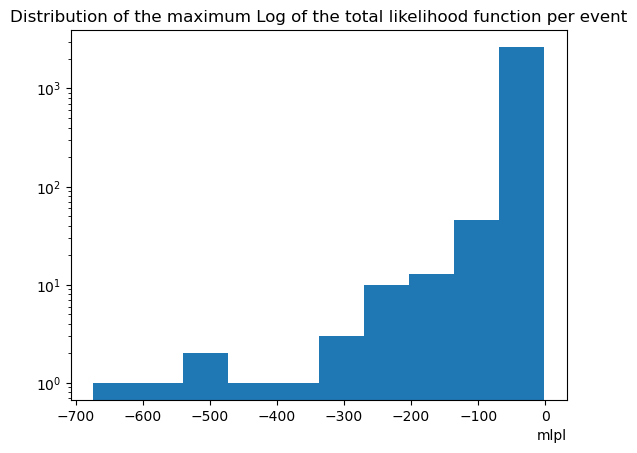

In [62]:
""" Getting the distribution for the EB data sample (data22_13p6TeV:data22_13p6TeV.00440499.physics_EnhancedBias.recon.AOD.
r14725_r14726_tid33689943_00) """
EB_dist = get_max_log_likelihood_dist("../data22_13p6TeV.00440499.physics_EnhancedBias.h5")
plot_distribution(EB_dist)

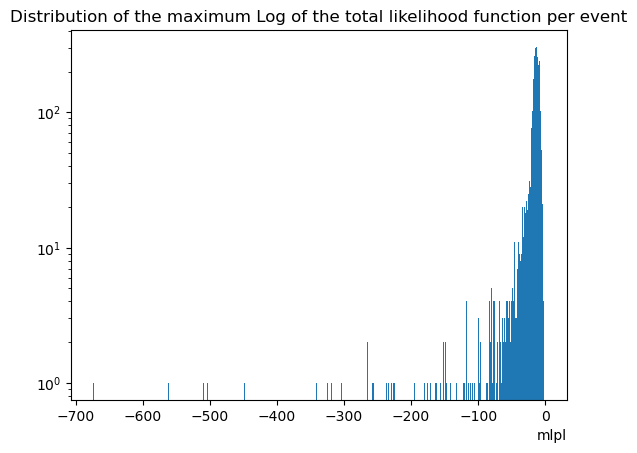

In [66]:
plot_distribution(EB_dist)